In [0]:
# Import the machine learning libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [0]:
# Load the MNIST dataset.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [32]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


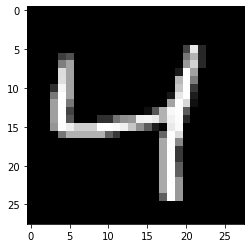

In [33]:
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))

In [34]:
# For faster training on smaller dataset
only_zeros = X_train[y_train==0]
print(only_zeros.shape)

(5923, 28, 28)


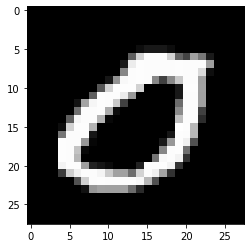

In [35]:
plt.imshow(only_zeros[70], cmap=plt.get_cmap('gray'))

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [0]:
np.random.seed(42)
tf.random.set_seed(42)
codings_size = 100

In [0]:
generator = Sequential()
generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
generator.add(Dense(150, activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [0]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [0]:
GAN = Sequential([generator, discriminator])

In [0]:
discriminator.trainable = False

In [0]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [43]:
GAN.layers

In [44]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28)            143634    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 132951    
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [45]:
GAN.layers[0].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_8 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [46]:
GAN.layers[1].summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


In [47]:
batch_size = 32
#my_data = X_train
my_data = only_zeros # For faster training on smaller dataset
print(my_data.shape)

(5923, 28, 28)


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [49]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [0]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
epochs = 1

In [52]:
# Training Loop.
%%time

# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE
CPU times: user 3.73 s, sys: 234 ms, total: 3.96 s
Wall time: 3.68 s


In [53]:
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

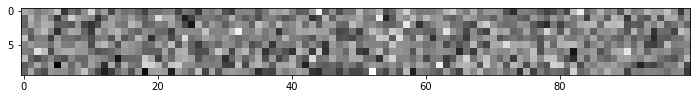

In [54]:
plt.figure(figsize=(12, 3))
plt.imshow(noise, cmap=plt.get_cmap('gray'))

In [55]:
%%time
image = generator(noise)

CPU times: user 5.78 ms, sys: 0 ns, total: 5.78 ms
Wall time: 5.35 ms


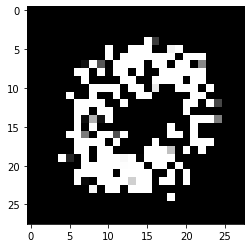

In [56]:
plt.imshow(image[3], cmap=plt.get_cmap('gray'))

In [57]:
image.shape

TensorShape([10, 28, 28])

0


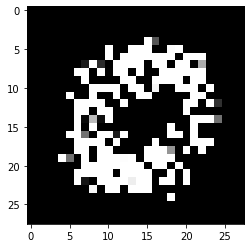

1


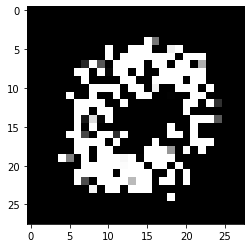

2


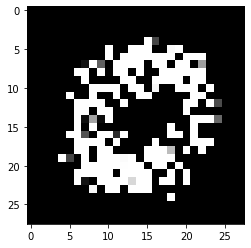

3


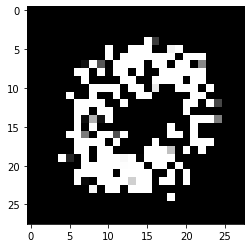

4


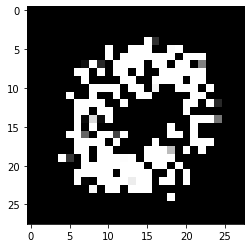

5


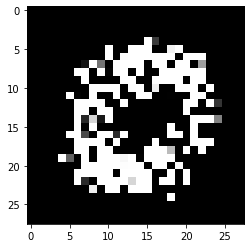

6


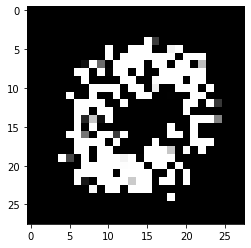

7


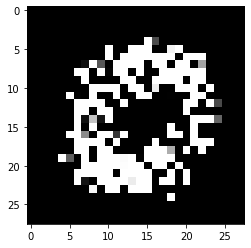

8


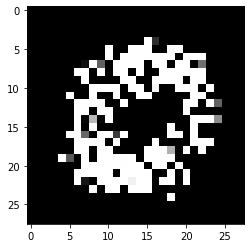

9


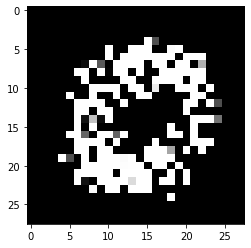

In [58]:
# Visulize.
for i in range(0, len(image)):
    print(i)
    tmp = image[i,:,:]
    #tmp = tmp.reshape(28, 28)
    plt.imshow(tmp, cmap='gray')
    plt.show()